In [ ]:
# todo appliquer sclaer sur modeles à optimiser (randomforest...

# Set up

Python librairies imports :

In [1]:
%%capture captured_output
!pip install jupyter_ai

In [ ]:
#%%capture captured_output
#!pip install jupyter_ai_magics

In [2]:
%%capture captured_output
!pip install hyperopt
!pip install xgboost
!pip install lime
!pip install shap
!pip install evidently

In [5]:
# File system management
import os
import pickle
import dill

from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler 

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as ltb

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# Data drift
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(palette="Set1")

Define work location :

In [6]:
project_path = "/Users/laureagrech/Downloads/OC_DS_P7/notebooks/"

# Change directory
os.chdir(project_path)

Load data :

In [7]:
# Load data
data = pd.read_csv("data/processed/train_feature_engineering.csv", index_col=[0])
data_test = pd.read_csv("data/processed/test_feature_engineering.csv", index_col=[0])

# Functions

In [8]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve, fbeta_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Fonction pour afficher la matrice de confusion
def display_confusion_matrix(y_true, y_pred, model_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"Matrice de confusion pour {model_name} :")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print("\n")

# Fonction améliorée pour calculer et tracer la courbe ROC avec le seuil optimal
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y (baseline)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr + tpr - 1))]
        o_fpr = fpr[np.argmin(np.abs(fpr + tpr - 1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr + tpr - 1))]

        # Display best threshold point on the ROC curve
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

# Fonction pour calculer les résultats de classification
def compute_classification_results(model, model_name, x_test, y_test, beta=2, disp_best_th=False):
    
    # Prédire la probabilité de la classe 1 (défaut de remboursement)
    y_pred_proba = model.predict_proba(x_test)[:,1]

    # Prédire les classes
    y_pred = model.predict(x_test)

    # Afficher la matrice de confusion
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Tracer la courbe ROC et calculer le score AUC
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name, disp_best_th=disp_best_th)

    # Calculer le rapport de classification
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(clf_report)

    # Calculer le F-beta score
    fbeta = fbeta_score(y_test, y_pred, beta=beta)
    print(f"F-beta score (beta={beta}) =", fbeta)

    return fbeta, auc_score, clf_report


In [10]:
# Return the best model from hyperopt trials
def trials_best_model(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    min_loss_idx = np.argmin(losses)
    best_trial_obj = valid_trial_list[min_loss_idx]
    print("Best result :", best_trial_obj['result']['loss'])
    return best_trial_obj['result']['model']

# MLFlow

In [12]:
%%capture captured_output
!pip install mlflow

Set up of MLFlow tracking.

In [13]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Create experiment
experiment_name = 'credit_scoring'
mlflow.set_experiment(experiment_name)
mlflow.end_run()

La fonction log_mlflow est conçue pour enregistrer les paramètres, les métriques, et le modèle dans l'environnement MLflow.

In [14]:
# Function to log model to mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None,
               train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

MLflow est utilisé pour suivre et enregistrer les résultats d'entraînement de modèles de machine learning. MLflow est un outil de gestion du cycle de vie des modèles, qui permet de logger (enregistrer) des hyperparamètres, des métriques, des artefacts (comme les modèles eux-mêmes) et d'autres informations pertinentes pour le suivi des expériences de machine learning.

# Data preparation

In [15]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET].to_numpy()
features = data.drop(columns=TARGET).to_numpy()
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

## Missing values

In [16]:
# Check missing values
nan_values = data.isna().sum().sum()
print("Missing values = {} ({:.2%})".format(nan_values, nan_values/data.size))

Missing values = 37539165 (20.11%)


I fill the missing values with a simple imputer.

In [17]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)

## Split data

I split the data into training and testing sets.

In [18]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [19]:
# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Balance data

In [20]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target statistics: Counter({0.0: 226201, 1.0: 19804})
Testing target statistics: Counter({0.0: 56481, 1.0: 5021})
Ratio is 1:11


I will define a pipeline that first transforms the training dataset with SMOTE then fits the model.

In [21]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
# steps = [('over', over)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train) #fit_resample à revoir concept

print("Training target statistics:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))

Training target statistics: Counter({0.0: 113100, 1.0: 113100})
Testing target statistics: Counter({0.0: 56481, 1.0: 5021})


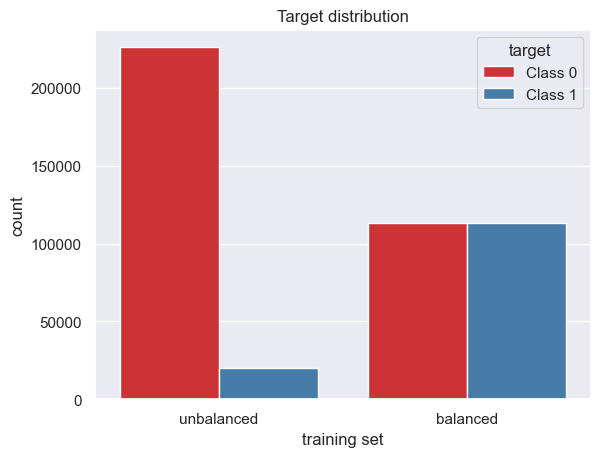

In [22]:
# Display barplot of distribution to see Smote impact on data
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title("Target distribution")
plt.show()

## Custom loss function

Rule : cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)

Le make scorer fonctionne bien pour calculer un score métier en se basant sur la matrice de confusion, avec une pénalisation spécifique pour les faux négatifs.
On adapte le paramètre beta pour le F-beta score dans make_scorer. Le F-beta score permet de donner plus ou moins d'importance au Recall (sensibilité) ou à la Précision, selon la valeur de beta.

In [ ]:
#avec beta score

In [ ]:
from sklearn.metrics import fbeta_score

# Exemple avec beta = 2 pour accorder plus d'importance au Recall
# Fonction pour calculer le F-beta score avec un beta ajusté
def fbeta_scorer(beta=2):
    return make_scorer(fbeta_score, beta=beta)

si tu souhaites uniquement utiliser le F-beta score pour optimiser ton modèle et que ton objectif principal est de minimiser les faux négatifs (FN), voici comment tu peux procéder.

Le F-beta score est idéal pour cette tâche, car tu peux ajuster le paramètre beta pour donner plus de poids au recall (rappel), ce qui est crucial si tu veux réduire les faux négatifs. Un faux négatif se produit lorsqu'une personne qui ne peut pas rembourser le crédit est identifiée à tort comme pouvant le faire. En augmentant le recall, tu maximises la détection des vrais cas de clients qui ne peuvent pas rembourser, ce qui réduit les faux négatifs

In [ ]:
#avec cost score

from sklearn.metrics import confusion_matrix,  make_scorer

# Fonction pour calculer le score personnalisé basé sur la matrice de confusion et F-beta
def cost_score_function(y_true, y_pred, y_pred_proba, beta=2):
    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Custom profit score basé sur la règle métier
    cost_score = (tp * 0) + (tn * 0) - (fp * 10) - (fn * 100)
    cost_score = (- (fp * 10) - (fn * 100))/(-fp-fn))# normaliser pour avoir sortie positive entre 0 et 1
    
    # Calcul du F-beta score avec le beta ajusté
    #fbeta = fbeta_score(y_true, y_pred, beta=beta)
    
    # Combiner les deux scores 
    #combined_score = profit_score + fbeta * 100  # Mettre plus de poids sur F-beta si nécessaire
    return combined_score
    #return combined_score

# Créer un scorer pour GridSearchCV avec make_scorer
business_score = make_scorer(cost_score_function, greater_is_better=False, needs_proba=False)



La matrice de confusion est un tableau qui décompose les prédictions d'un modèle de classification en quatre catégories :

TN (True Negatives True Target=0) : Cas où le modèle a correctement prédit la classe négative (un client remboursera son crédit et le modèle l'a bien prédit).

FP (False Positives Faux Target =1) : Cas où le modèle a prédit la classe positive, mais c'était en réalité négatif (un client est prédit comme ne remboursant pas alors qu'il rembourse en réalité).

FN (False Negatives Faux Target =0) : Cas où le modèle a prédit la classe négative, mais c'était en réalité positif (un client est prédit comme remboursant, mais il ne rembourse pas en réalité).

TP (True Positives Vrai Target =1) : Cas où le modèle a correctement prédit la classe positive (un client ne remboursera pas et le modèle l'a bien prédit).

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Modèle LightGBM
model = LGBMClassifier(random_state=42)

# Paramètres pour GridSearchCV
param_grid = {
    'max_depth': [10, 20, 30],
    'num_leaves': [20, 40, 60],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Exécuter GridSearchCV avec le scorer combiné
grid_search = GridSearchCV(model, param_grid, scoring=fbeta_scorer, cv=5)
grid_search.fit(x_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score combiné:", grid_search.best_score_)

# Prédictions sur le jeu de test
y_pred = grid_search.best_estimator_.predict(x_test)

# Afficher la matrice de confusion
combined_profit_fbeta_score(y_test, y_pred, beta=2, display_confusion=True)


In [23]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix

# Fonction pour afficher la matrice de confusion et utiliser le F-beta score
def fbeta_scorer(beta=2):
    return make_scorer(fbeta_score, beta=beta)

# Affichage de la matrice de confusion et des scores
def display_confusion_matrix_and_results(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Afficher la matrice de confusion
    print("Matrice de confusion :")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    
    # Calculer le F-beta score pour l'évaluation finale
    fbeta = fbeta_score(y_true, y_pred, beta=2)
    print(f"F-beta score (beta=2): {fbeta}")

# Modèle LightGBM
model = LGBMClassifier(random_state=42)

# Paramètres pour GridSearchCV
param_grid = {
    'max_depth': [10, 20, 30],
    'num_leaves': [20, 40, 60],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Créer le F-beta scorer avec beta=2 (pour minimiser les FN)
fbeta_scorer = fbeta_scorer(beta=2)

# Exécuter GridSearchCV avec le F-beta scorer
grid_search = GridSearchCV(model, param_grid, scoring=fbeta_scorer, cv=5)
grid_search.fit(x_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score F-beta:", grid_search.best_score_)

# Prédictions sur le jeu de test
y_pred = grid_search.best_estimator_.predict(x_test)

# Afficher la matrice de confusion et le F-beta score
display_confusion_matrix_and_results(y_test, y_pred)


[LightGBM] [Info] Number of positive: 15843, number of negative: 180961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61172
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 565
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080501 -> initscore=-2.435554
[LightGBM] [Info] Start training from score -2.435554
[LightGBM] [Info] Number of positive: 15843, number of negative: 180961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61208
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 565
[LightGBM]

# Classification

Les métriques de précision, rappel, F1-score, support, et un score métier personnalisé sont couramment utilisées pour évaluer la performance des modèles de classification en machine learning, spécialement dans les contextes où les décisions ont des conséquences financières ou d'autres impacts importants.

1. Précision (Precision)
La précision mesure la justesse des prédictions positives faites par le modèle. Elle est définie comme le ratio des vrais positifs (TP) par rapport à la somme des vrais positifs et des faux positifs (FP):


Interprétation : Une précision élevée indique qu'une grande proportion des identifications positives du modèle sont correctes.

2. Rappel (Recall) ou Sensibilité
Le rappel mesure la capacité du modèle à détecter tous les cas positifs réels. Il est défini comme le ratio des vrais positifs par rapport à la somme des vrais positifs et des faux négatifs (FN):

Rappel
: Un rappel élevé signifie que le modèle est capable de détecter une grande partie des cas positifs réels. C'est crucial dans les situations où ne pas détecter les positifs (comme les maladies ou les fraudes) peut avoir de graves conséquences.

3. F1-Score
Le F1-score est la moyenne harmonique de la précision et du rappel. Il combine les deux métriques en une seule, ce qui est particulièrement utile lorsque vous avez besoin d'un équilibre entre la précision et le rappel:
Interprétation : Le F1-score est particulièrement utile quand les coûts des faux positifs et faux négatifs sont très équilibrés, ou lorsque les distributions des classes sont déséquilibrées.

4. Support
Le support est le nombre de cas réels pour chaque classe dans les données testées. Pour chaque classe, il indique combien d'exemples de cette classe existent dans les données.

Interprétation : Le support n'influence pas directement la performance du modèle mais donne un contexte sur la significativité des métriques de performance comme le rappel et la précision.

5. Score Métier
Un score métier est une métrique personnalisée qui évalue la performance du modèle selon des critères spécifiquement importants pour l'entreprise ou l'application. Il peut intégrer des coûts ou des bénéfices associés aux différentes prédictions du modèle (TP, FP, TN, FN). Par exemple :

Interprétation : Cette métrique est utilisée pour maximiser le rendement économique du modèle ou pour minimiser les risques spécifiques. Elle aide à prendre des décisions stratégiques sur le déploiement du modèle en production en alignant les objectifs du modèle avec les objectifs financiers ou opérationnels de l'organisation.
Ensemble, ces métriques fournissent une vue complète de la performance d'un modèle de classification, aidant les développeurs à comprendre ses forces et ses faiblesses et à faire des ajustements pour améliorer son efficacité dans des contextes pratiques.

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, fbeta_score
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour afficher la matrice de confusion
def display_confusion_matrix(y_true, y_pred, model_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"Matrice de confusion pour {model_name} :")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print("\n")

# Fonction pour calculer et tracer la courbe ROC
def compute_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return auc_score

# Fonction pour calculer les résultats de classification
def compute_classification_results(model, model_name, x_test, y_test, beta=2):
    
    # Prédire la probabilité de la classe 1 (défaut de remboursement)
    y_pred_proba = model.predict_proba(x_test)[:,1]

    # Prédire les classes
    y_pred = model.predict(x_test)

    # Afficher la matrice de confusion
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Tracer la courbe ROC et calculer le score AUC
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Calculer le rapport de classification
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(clf_report)

    # Calculer le F-beta score
    fbeta = fbeta_score(y_test, y_pred, beta=beta)
    print(f"F-beta score (beta={beta}) =", fbeta)

    return fbeta, auc_score, clf_report


# DummyClassifier

Matrice de confusion pour DummyClassifier :
TN: 28238, FP: 28243, FN: 2487, TP: 2534




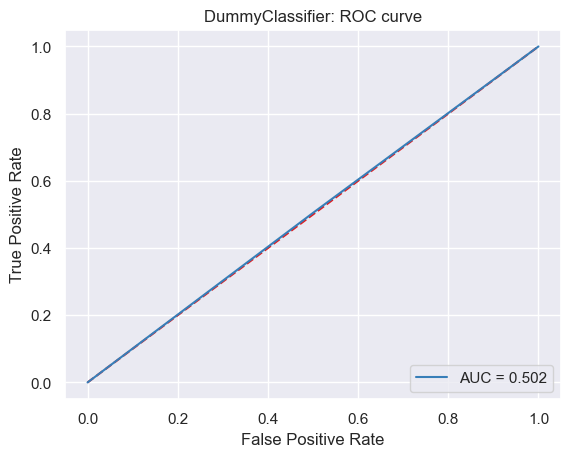

,precision,recall,f1-score,support
0.0,0.919056,0.499956,0.647616,56481.000000
1.0,0.082334,0.504680,0.141572,5021.000000
accuracy,0.500341,0.500341,0.500341,0.500341
macro avg,0.500695,0.502318,0.394594,61502.000000
weighted avg,0.850746,0.500341,0.606303,61502.000000


F-beta score (beta=2) = 0.2491103202846975


2024/10/04 19:23:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Cross-validated F-beta scores: [0.50350046 0.50350046 0.50350046 0.50350046 0.50350046]
Mean F-beta score: 0.5035004596563185


In [26]:
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import cross_val_score

# Create DummyClassifier model
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Créer le F-beta scorer avec beta=2
fbeta_scorer = make_scorer(fbeta_score, beta=2)

# Utiliser cross_val_score avec le F-beta scorer
dc_fbeta_scores = cross_val_score(dc, x_res, y_res, scoring=fbeta_scorer, cv=5)

# Fit the model (sur tout le dataset)
dc.fit(x_res, y_res)

# Compute results
dc_fbeta_score, dc_auc, dc_report = compute_classification_results(dc, dc_name, x_test, y_test)

# Save logs
log_mlflow(dc, dc_name, auc_score=dc_auc, custom_score=dc_fbeta_score,
           f1_score=dc_report.loc['weighted avg', 'f1-score'], 
           acc_score=dc_report.loc['accuracy', 'f1-score'],
           train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])

# Afficher les résultats de cross-validation avec le F-beta scorer
print(f"Cross-validated F-beta scores: {dc_fbeta_scores}")
print(f"Mean F-beta score: {dc_fbeta_scores.mean()}")



La matrice de confusion que vous avez fournie représente les performances d'un modèle de classification, ici spécifiquement un DummyClassifier, qui est souvent utilisé comme point de référence pour comparer les performances de modèles plus sophistiqués. Voici comment interpréter chaque partie de cette matrice de confusion :

Composition de la Matrice de Confusion
Axe vertical (True Label) : Les vraies étiquettes des données, où 0.0 représente la classe négative (par exemple, clients sans difficulté de paiements) et 1.0 représente la classe positive (par exemple, clients avec difficultés de paiements).
Axe horizontal (Predicted Label) : Les prédictions du modèle, où 0.0 et 1.0 suivent la même logique que les étiquettes vraies.
Valeurs dans la Matrice
Haut Gauche (True Negative, TN) : Nombre de prédictions correctes où le modèle a prédit la classe négative correctement, soit 28,238.
Haut Droit (False Positive, FP) : Nombre de prédictions incorrectes où le modèle a prédit la classe positive alors que la vraie classe était négative, soit 28,243.
Bas Gauche (False Negative, FN) : Nombre de prédictions incorrectes où le modèle a prédit la classe négative alors que la vraie classe était positive, soit 2,487.
Bas Droit (True Positive, TP) : Nombre de prédictions correctes où le modèle a prédit la classe positive correctement, soit 2,534.
Interprétation
Performance Générale : En regardant les valeurs TP et TN, vous pouvez voir que le modèle a une performance relativement équilibrée en termes de prédiction des deux classes, mais avec une très légère préférence pour prédire incorrectement la classe positive comme négative (FP élevé).
Précision et Rappel :
Précision pour la classe 0 est calculée comme 
TN
/
(
TN
+
FN
)
TN/(TN+FN), et pour la classe 1 comme 
TP
/
(
TP
+
FP
)
TP/(TP+FP).
Rappel pour la classe 0 est 
TN
/
(
TN
+
FP
)
TN/(TN+FP), et pour la classe 1 
TP
/
(
TP
+
FN
)
TP/(TP+FN).
Équilibre des Erreurs : La proportion de FP et FN montre que le modèle est aussi susceptible de prédire incorrectement les vrais négatifs que les vrais positifs.
Conclusion
La performance de ce DummyClassifier suggère qu'il prédit les classes en se basant probablement sur une distribution aléatoire ou une stratégie très simple, ce qui entraîne un grand nombre de faux positifs et de faux négatifs. Cette performance peut servir de ligne de base pour évaluer des modèles plus avancés. Un modèle utile devrait idéalement surpasser ce DummyClassifier en réduisant significativement les erreurs de type FP et FN tout en augmentant les valeurs TN et TP.

# LogisticRegression

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matrice de confusion pour LogisticRegression :
TN: 53458, FP: 3023, FN: 4505, TP: 516




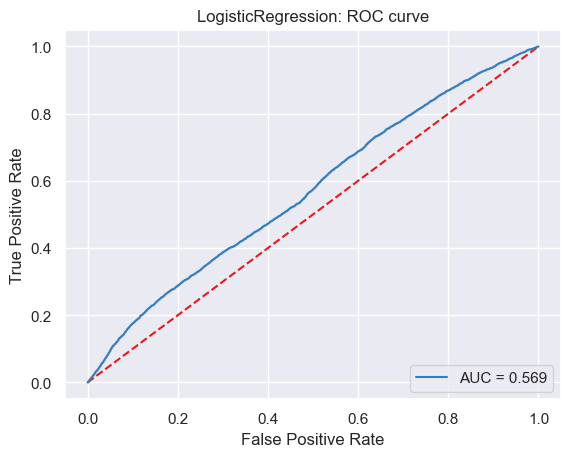

,precision,recall,f1-score,support
0.0,0.922278,0.946478,0.934221,56481.000000
1.0,0.145804,0.102768,0.120561,5021.000000
accuracy,0.877597,0.877597,0.877597,0.877597
macro avg,0.534041,0.524623,0.527391,61502.000000
weighted avg,0.858887,0.877597,0.867794,61502.000000


F-beta score (beta=2) = 0.10921559497100283


2024/10/04 19:24:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CPU times: user 1min 49s, sys: 2.7 s, total: 1min 52s
Wall time: 39.2 s


In [27]:
%%time

# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE)
lr_name = 'LogisticRegression'

# Train model
lr.fit(x_res, y_res)

# Compute results
lr_fbeta_score, lr_auc, lr_report = compute_classification_results(lr, lr_name, x_test, y_test)

# Save logs
log_mlflow(lr, lr_name, auc_score=lr_auc, custom_score=dc_fbeta_score,
           f1_score=lr_report.loc['weighted avg', 'f1-score'], 
           acc_score=lr_report.loc['accuracy', 'precision'],
           train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])

# RandomForest

Matrice de confusion pour RandomForest :
TN: 56311, FP: 170, FN: 4889, TP: 132




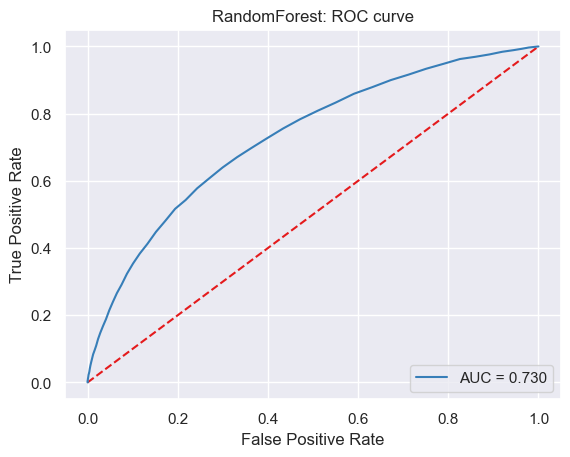

,precision,recall,f1-score,support
0.0,0.920114,0.996990,0.957011,56481.000000
1.0,0.437086,0.026290,0.049596,5021.000000
accuracy,0.917743,0.917743,0.917743,0.917743
macro avg,0.678600,0.511640,0.503303,61502.000000
weighted avg,0.880680,0.917743,0.882930,61502.000000


F-beta score (beta=2) = 0.03237515942313352


2024/10/04 19:27:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CPU times: user 2min 35s, sys: 2.04 s, total: 2min 37s
Wall time: 2min 37s


In [28]:
%%time

# Create random forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_name = 'RandomForest'

# Train model
rf.fit(x_res, y_res)

# Compute results
rf_fbeta_score, rf_auc, rf_report = compute_classification_results(rf, rf_name, x_test, y_test)

# Save logs
rf_params = rf.get_params()
log_mlflow(rf, rf_name,
           custom_score=dc_fbeta_score,
           auc_score=rf_auc,
           f1_score=rf_report.loc['weighted avg', 'f1-score'], 
           acc_score=rf_report.loc['accuracy', 'precision'],
           n_estimator=rf_params['n_estimators'],
           max_depth=rf_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

# XGBoost

Matrice de confusion pour XGBoost :
TN: 55075, FP: 1406, FN: 4125, TP: 896




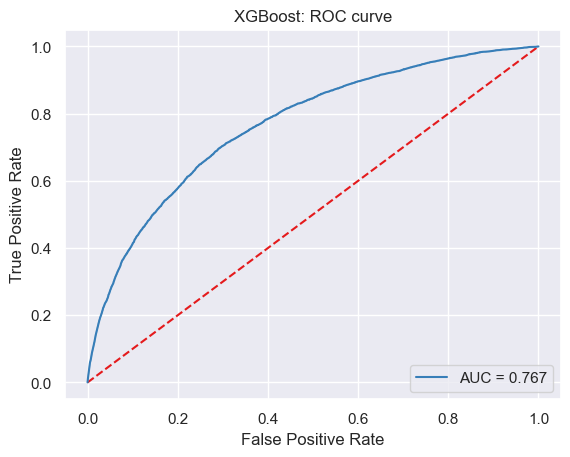

,precision,recall,f1-score,support
0.0,0.930321,0.975107,0.952187,56481.000000
1.0,0.389227,0.178451,0.244708,5021.000000
accuracy,0.910068,0.910068,0.910068,0.910068
macro avg,0.659774,0.576779,0.598448,61502.000000
weighted avg,0.886146,0.910068,0.894429,61502.000000


F-beta score (beta=2) = 0.20012507817385866


2024/10/04 19:27:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CPU times: user 1min 27s, sys: 7.6 s, total: 1min 34s
Wall time: 35.4 s


In [29]:
%%time

# Create XGBoost classifier
xgbc = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgbc_name = 'XGBoost'

# Train model
xgbc.fit(x_res, y_res)

# Compute results
xgbc_fbeta_score, xgbc_auc, xgbc_report = compute_classification_results(xgbc, xgbc_name, x_test, y_test)

# Save logs
xgbc_params = xgbc.get_params()
log_mlflow(xgbc, xgbc_name,
           custom_score=dc_fbeta_score,
           auc_score=xgbc_auc,
           f1_score=xgbc_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbc_report.loc['accuracy', 'precision'],
           n_estimator=xgbc_params['n_estimators'],
           max_depth=xgbc_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

# LightGBM

[LightGBM] [Info] Number of positive: 113100, number of negative: 113100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135080
[LightGBM] [Info] Number of data points in the train set: 226200, number of used features: 569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Matrice de confusion pour LightGBM :
TN: 55590, FP: 891, FN: 4355, TP: 666




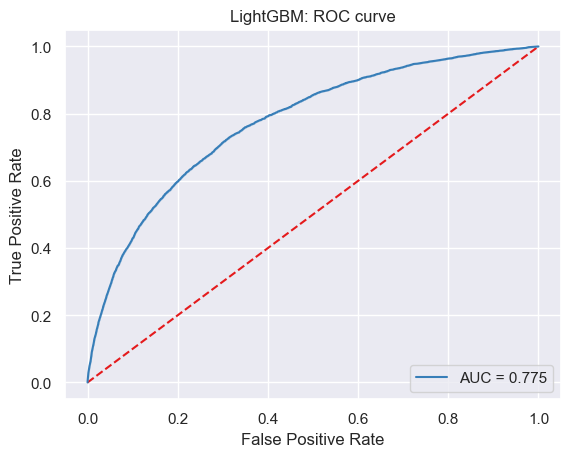

,precision,recall,f1-score,support
0.0,0.927350,0.984225,0.954941,56481.000000
1.0,0.427746,0.132643,0.202493,5021.000000
accuracy,0.914702,0.914702,0.914702,0.914702
macro avg,0.677548,0.558434,0.578717,61502.000000
weighted avg,0.886563,0.914702,0.893512,61502.000000


F-beta score (beta=2) = 0.1538745898988032


2024/10/04 19:28:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CPU times: user 1min 34s, sys: 9.84 s, total: 1min 44s
Wall time: 38.3 s


In [30]:
%%time

# Create LightGBM classifier
lgbm = ltb.LGBMClassifier(random_state=RANDOM_STATE)
lgbm_name = 'LightGBM'

# Train model
lgbm.fit(x_res, y_res)

# Compute results
lgbm_fbeta_score, lgbm_auc, lgbm_report = compute_classification_results(lgbm, lgbm_name, x_test, y_test)

# Save logs
lgbm_params = lgbm.get_params()
log_mlflow(lgbm, lgbm_name,
           custom_score=dc_fbeta_score,
           auc_score=lgbm_auc,
           f1_score=lgbm_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbm_report.loc['accuracy', 'precision'],
           n_estimator=lgbm_params['n_estimators'],
           max_depth=lgbm_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

# Comparison

In [31]:
# Create results dataframe
res_df = pd.DataFrame({
    'Model':['Dummy', 'LogisticRegression', 'RandomForest', 'XGBoost', 'LightGBM'],
    'Business score': [dc_fbeta_score, lr_fbeta_score, rf_fbeta_score, xgbc_fbeta_score, lgbm_fbeta_score],
    'Accuracy': [dc_report.loc['accuracy', 'precision'],
                 lr_report.loc['accuracy', 'precision'],
                 rf_report.loc['accuracy', 'precision'],
                 xgbc_report.loc['accuracy', 'precision'],
                 lgbm_report.loc['accuracy', 'precision']],
    'Precision': [dc_report.loc['macro avg', 'precision'],
                 lr_report.loc['macro avg', 'precision'],
                 rf_report.loc['macro avg', 'precision'],
                 xgbc_report.loc['macro avg', 'precision'],
                 lgbm_report.loc['macro avg', 'precision']],
    'Recall': [dc_report.loc['macro avg', 'recall'],
               lr_report.loc['macro avg', 'recall'],
               rf_report.loc['macro avg', 'recall'],
               xgbc_report.loc['macro avg', 'recall'],
               lgbm_report.loc['macro avg', 'recall']],
    'F-1 score': [dc_report.loc['macro avg', 'f1-score'],
                  lr_report.loc['macro avg', 'f1-score'],
                  rf_report.loc['macro avg', 'f1-score'],
                  xgbc_report.loc['macro avg', 'f1-score'],
                 lgbm_report.loc['macro avg', 'f1-score']],
    'AUC score': [dc_auc, lr_auc, rf_auc, xgbc_auc, lgbm_auc],
})

display(res_df)

,Model,Business score,Accuracy,Precision,Recall,F-1 score,AUC score
0,Dummy,0.249110,0.500341,0.500695,0.502318,0.394594,0.502318
1,LogisticRegression,0.109216,0.877597,0.534041,0.524623,0.527391,0.568904
2,RandomForest,0.032375,0.917743,0.678600,0.511640,0.503303,0.729775
3,XGBoost,0.200125,0.910068,0.659774,0.576779,0.598448,0.767438
4,LightGBM,0.153875,0.914702,0.677548,0.558434,0.578717,0.774562


**The best model regarding our business score is the XGBoost model.**
<br>I decide to select this model for the project. 

Let's tune its hyperparameters.

# Hyperparametrization

XGBoost hyperparameter optimisation

In [ ]:
"""espace de recherche pour les hyperparamètres importants comme :

max_depth : La profondeur maximale des arbres de décision.
subsample : Fraction des données d'entraînement à utiliser pour chaque arbre.
colsample_bytree : Fraction des colonnes à échantillonner pour chaque arbre.
learning_rate : Taux d'apprentissage.
min_child_weight : Critère de régularisation (influence la complexité de l'arbre).
n_estimators : Nombre d'arbres dans le modèle."""


Testing parameters:                                   
{'colsample_bytree': 0.5, 'learning_rate': 0.30000000000000004, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.6798504887686936}
Mean F-beta score: 0.8226541677614693                 
Testing parameters:                                                               
{'colsample_bytree': 1.0, 'learning_rate': 0.30000000000000004, 'max_depth': 15, 'min_child_weight': 9, 'n_estimators': 350, 'subsample': 0.7493655740629295}
Mean F-beta score: 0.8221741484360123                                             
Testing parameters:                                                               
{'colsample_bytree': 1.0, 'learning_rate': 0.7000000000000001, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 450, 'subsample': 0.7440784579635843}
Mean F-beta score: 0.815011296613849                                              
Testing parameters:                                                               
{'c

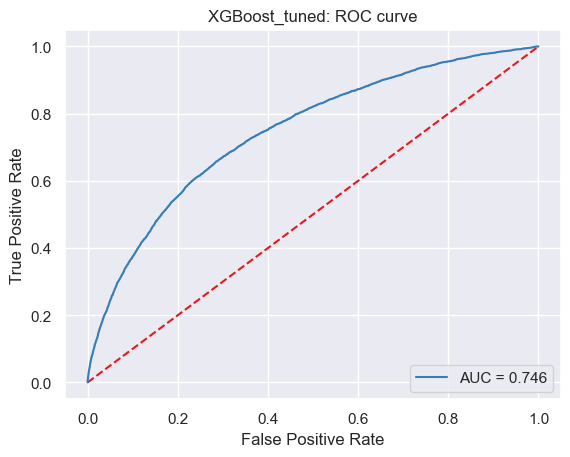

,precision,recall,f1-score,support
0.0,0.930448,0.966360,0.948064,56481.000000
1.0,0.331221,0.187413,0.239379,5021.000000
accuracy,0.902767,0.902767,0.902767,0.902767
macro avg,0.630835,0.576887,0.593722,61502.000000
weighted avg,0.881527,0.902767,0.890207,61502.000000


F-beta score (beta=2) = 0.20523446019629227


2024/10/04 20:04:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [37]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from hyperopt import fmin, tpe, STATUS_OK, Trials
import hyperopt.hp as hp
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# Créer un scorer pour le F-beta avec beta=2
fbeta_scorer = make_scorer(fbeta_score, beta=2)

# Create XGBoost classifier for optimisation
xgbt = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgbt_name = 'XGBoost_tuned'

# Possible values of hyperparameters
xgbt_space = {
    'max_depth': scope.int(hp.quniform("max_depth", 3, 18, 1)),
    'subsample': hp.uniform('subsample', 0.5, 1.),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.5),
    'learning_rate': hp.quniform('learning_rate', 0.1, 1, 0.1),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 10, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 50))
}

# Define objective function for optimization
def xgbt_tuning(params):
    print("Testing parameters: ", params)
    xgbt.set_params(**params)
    
    # Perform cross-validation with F-beta scorer
    score = cross_val_score(xgbt, x_res, y_res, scoring=fbeta_scorer, cv=5).mean()
    print(f"Mean F-beta score: {score}")
    
    return {"loss": -score, "status": STATUS_OK, "model": xgbt}

# Initialize trials object
xgbt_trials = Trials()

# Find best model with hyperopt
xgbt_best = fmin(fn=xgbt_tuning, space=xgbt_space, algo=tpe.suggest, max_evals=10, trials=xgbt_trials)

# Extract the best model from the trials
xgbt_best_model = xgbt_trials.best_trial['result']['model']
print(f"Best hyperparameters found: {xgbt_best}")

# Train the best model on the full training data
xgbt_best_model.fit(x_res, y_res)

# Compute results using your compute_classification_results function
xgbt_fbeta_score, xgbt_auc, xgbt_report = compute_classification_results(xgbt_best_model, xgbt_name, x_test, y_test)

# Save logs to MLflow
xgbt_params = xgbt_best_model.get_params()
log_mlflow(xgbt_best_model, xgbt_name,
           custom_score=xgbt_fbeta_score,
           auc_score=xgbt_auc,
           f1_score=xgbt_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbt_report.loc['accuracy', 'f1-score'],  # Fixed accuracy reference
           n_estimator=xgbt_params['n_estimators'],
           max_depth=xgbt_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])


The tuned model is slightly better than the standard xgboost.

In [38]:
xgb_score_imp = (xgbc_fbeta_score - xgbt_fbeta_score) / xgbc_fbeta_score
print("The XGBoost model improved the business score by {:.1%}".format(xgb_score_imp))

The XGBoost model improved the business score by -2.6%


The XGBoost tuned model is slightly better than the standard model (2.9%) but took more than one day of computation.

**I decide to keep the standard XGBoost model for this project.**

# Custom threshold

In [39]:
# Get proba predictions from xgbc model to be class 1 : repay failure
xgbc_proba = xgbc.predict_proba(x_test)[:,1]

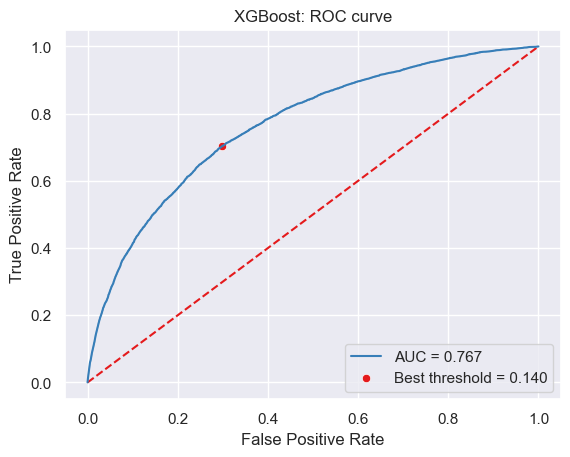

In [40]:
# Draw roc curve
auc_score = compute_roc_curve(y_test, xgbc_proba, model_name='XGBoost', disp_best_th=True)

The best prediction threshold is given by the point where the true positive rate and false positive rate are the lower.
<br>Here it gives us **0.140.**

Let's try different value of the prediction threshold : 
* 0.5 - Default
* 0.3 - Optimized
* 0.15 - Approximately the thresold given by the ROC curve
* 0.1 - Lower value than the thresold given by the ROC curve

In [41]:

# Compute confusion matrix with standard threshold (0.5)
xgbc_pred_std = xgbc_proba >= 0.5

# Afficher la matrice de confusion avec le seuil standard (0.5)
display_confusion_matrix(y_test, xgbc_pred_std, model_name='XGBoost (standard threshold)')

# Calculer le F-beta score à la place du business score
fbeta = fbeta_score(y_test, xgbc_pred_std, beta=2)
print(f"F-beta score (beta=2): {fbeta}")

# Calculer et afficher le rapport de classification
clf_report = pd.DataFrame(classification_report(y_test, xgbc_pred_std, output_dict=True)).transpose()
display(clf_report)


Matrice de confusion pour XGBoost (standard threshold) :
TN: 55075, FP: 1406, FN: 4125, TP: 896


F-beta score (beta=2): 0.20012507817385866


,precision,recall,f1-score,support
0.0,0.930321,0.975107,0.952187,56481.000000
1.0,0.389227,0.178451,0.244708,5021.000000
accuracy,0.910068,0.910068,0.910068,0.910068
macro avg,0.659774,0.576779,0.598448,61502.000000
weighted avg,0.886146,0.910068,0.894429,61502.000000


In [ ]:
# Compute confusion matrix with custom threshold (0.3)
xgbc_pred_cstm = xgbc_proba >= 0.3
display_confusion_matrix(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.3)')
fbeta = fbeta_score(y_test, xgbc_pred_cstm)
print("Business score =", business_score)
auc_score = compute_roc_curve(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.3)')
clf_report = pd.DataFrame(classification_report(y_test, xgbc_pred_cstm, output_dict=True)).transpose()
display(clf_report)

In [ ]:
# Compute confusion matrix with custom threshold (0.15)
xgbc_pred_cstm = xgbc_proba >= 0.15
display_confusion_matrix(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.15)')
fbeta = fbeta_score(y_test, xgbc_pred_cstm)
print("Business score =", fbeta)
auc_score = compute_roc_curve(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.15)')
clf_report = pd.DataFrame(classification_report(y_test, xgbc_pred_cstm, output_dict=True)).transpose()
display(clf_report)

In [ ]:
# Compute confusion matrix with custom threshold (0.1)
xgbc_pred_cstm = xgbc_proba >= 0.1
display_confusion_matrix(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.1)')
fbeta = fbeta_score(y_test, xgbc_pred_cstm)
print("Business score =", fbeta)
auc_score = compute_roc_curve(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.1)')
clf_report = pd.DataFrame(classification_report(y_test, xgbc_pred_cstm, output_dict=True)).transpose()
display(clf_report)

# Feature importance

## LIME

In [ ]:
# # Create lime explainer
lime_explainer = lime_tabular.LimeTabularExplainer(x_res, mode="classification",
                                                   class_names=['REPAY SUCCESS', 'REPAY FAILURE'],
                                                   feature_names=features_names)

In [ ]:
idx = 1001

print("Prediction : ", xgbc.predict(x_test)[idx])
print("Actual :     ", y_test[idx])

explanation = lime_explainer.explain_instance(x_test[idx], xgbc.predict_proba)

explanation.show_in_notebook()
explanation.as_list()

## SHAP

In [ ]:
# Compute shap values
shap_explainer = shap.TreeExplainer(xgbc, feature_names=features_names)
shap_values = shap_explainer(x_res)
test_shap_values = shap_explainer(x_test)

In [ ]:
# Explain instance
shap.initjs()
shap.plots.force(test_shap_values[idx])

In [ ]:
shap.plots.waterfall(test_shap_values[idx])
shap.plots.bar(test_shap_values[idx])

The LIME explainer seems to have troubles to explain instances.
<br>I decide to keep the SHAP explainer for this project.

# Feature importances

I use the XGBoost feature_importances_ built in method to get the feature importance of the trained model.

In [ ]:
# Get feature importance 15 first values
values = sorted(zip(xgbc.feature_importances_, features_names), reverse=True)[:15]

# Draw feature importances chart
plt.title("XGBoost: Feature importances")
sns.barplot(x=np.array(list(zip(*values))[0]), y=np.array(list(zip(*values))[1]))
plt.xlabel('Importances')
plt.show()

I also display the feature importances based on the SHAP values (only on the test set!)

In [ ]:
# Display feature importance
shap.summary_plot(test_shap_values, max_display=15,
                  class_names=['Repay success', 'Repay failure'],
                  plot_type='bar', plot_size=(15,10),
                  title='Feature importances (SHAP values)')

# Export

I export the XGBoost default model (selected as best model)

In [ ]:
# Best model
best_model = xgbc

# Serialize model
filename = 'models/xgboost_classifier.pckl'
pickle.dump(best_model, open(filename, 'wb'))

I export the SHAP explainer based on the XGBoost default model.

In [ ]:
# Serialize explainer
filename = 'models/xgboost_shap_explainer.pckl'
pickle.dump(shap_explainer, open(filename, 'wb'))

# Serialize explainer
# with open('models/xgboost_shap_explainer.pckl', 'wb') as f:
#     dill.dump(shap_explainer, f)

In [ ]:
#saved info for api:
#pickle.dump(best_model, open(filename, 'wb'))
          #pickle.dump(shap_explainer, open(filename, 'wb'))
                  #
